# Phase 3 Data Science Training Notebook

In [1]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [2]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Import Data from Train Dataset, 50,000 data entries

In [3]:
import os



meta_dir = os.path.join('cifar-10-batches-py', 'batches.meta')
metaData = unpickle(meta_dir)
train_data = None
train_labels = []
train_filenames = []
for x in range(1,6):
    batch="data_batch_"+ str(x)
    Datadir = os.path.join('cifar-10-batches-py', batch)
    rawdata = unpickle(Datadir)
    if x == 1:
        train_data = rawdata[b'data']
    else:
        train_data = np.vstack((train_data, rawdata[b'data']))
    #train_filenames += rawdata[b'filenames']
    train_labels += rawdata[b'labels']
train_data = train_data.reshape((len(train_data), 3, 32, 32))
train_data = np.rollaxis(train_data, 1, 4)

print(train_data.shape)
train_labels = np.array(train_labels)
print(train_labels.shape)
#train_filenames = np.array(train_filenames)
#print(train_filenames.shape)
#print(x)

#data = unpickle(Datadir)

(50000, 32, 32, 3)
(50000,)


Import remaining dataset from test batch, 10,000 data entries

In [4]:

Datadir = os.path.join('cifar-10-batches-py', "test_batch")
rawTestData = unpickle(Datadir)
test_data = rawTestData[b'data']
#test_filenames = rawTestData[b'filenames']
test_labels = rawTestData[b'labels']


test_data = test_data.reshape((len(test_data), 3, 32, 32))
test_data = np.rollaxis(test_data, 1, 4)
#test_filenames = np.array(test_filenames)
test_labels = np.array(test_labels)
print(test_data.shape)
print(test_labels.shape)


(10000, 32, 32, 3)
(10000,)


The dataset has now been loaded in correctly, as the shape of the data matches what we expect from the cifar-10 page, being a combination of 60,000 images (both data_batch and test_batch), arranged in 32*32 with 3 layers for different r g b values https://www.cs.toronto.edu/~kriz/cifar.html

Mayb more Exploratory shtuff here

In [5]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_name = load_label_names()

In [6]:
train_data.max()

255

In [7]:
train_data.min()

0

In [8]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [9]:
np.unique(test_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

Here are 5 Images from each Label within the dataset

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


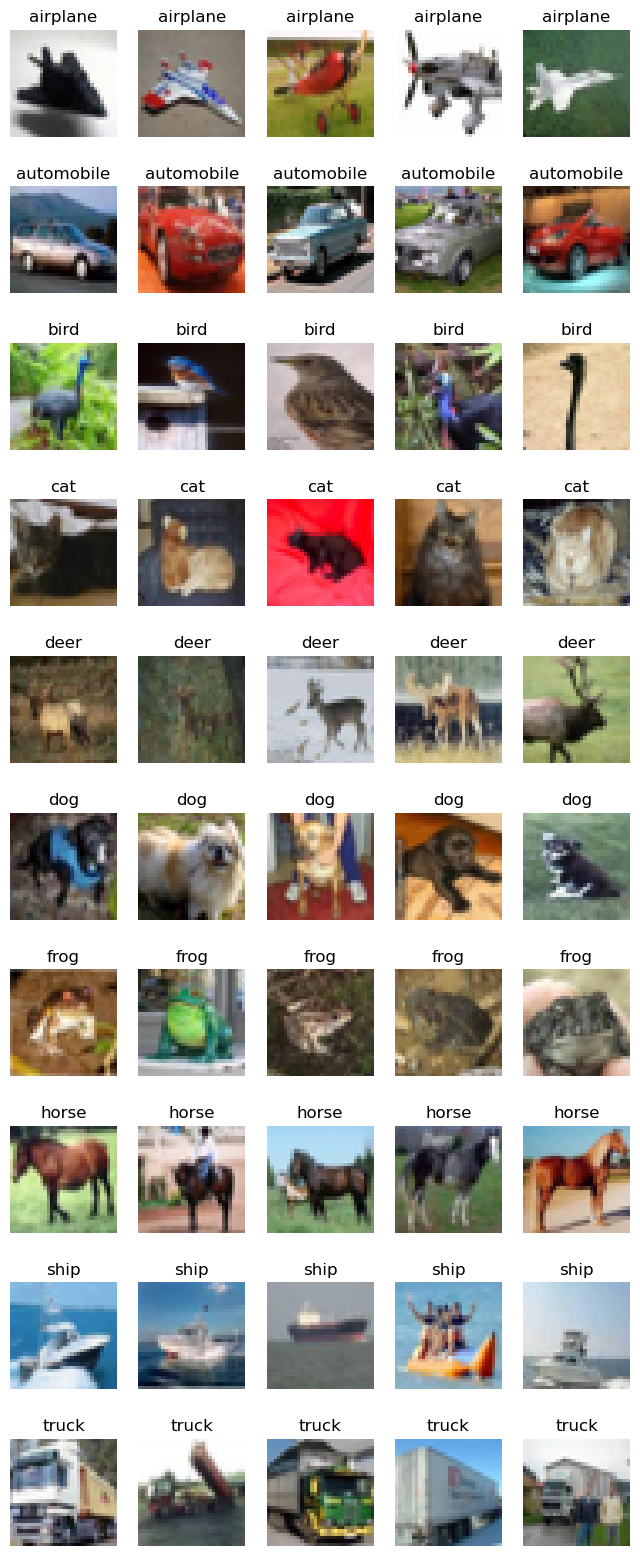

In [10]:
import matplotlib.pyplot as plt

print(label_name)

plt.figure(figsize=(8, 20))

for label in range(10): # Does not include 10.
    search_results = np.where(train_labels == label)[0][:5]

    for index, img_index in enumerate(search_results):
        current_index = label * 5 + index + 1
        ax = plt.subplot(10,5, current_index)
        plt.imshow(train_data[img_index])
        plt.title(label_name[label])
        plt.axis("off")

The Label I will be investigating will be the ship Label

# Data Processing

Now that I have chosen the ship label, I will need to clean the dataset of the other labels

Keep there data, and there labels, but change them to 0, and change label 8 to 1

In [11]:
# 8 is the label for ship, have this equal to 1, and non ships equal to zero, might need to hot encode idk

binary_train_labels = []
#print(label_name[8])
for label in train_labels:
    #print(train_labels[label])
    if label != 8:
        #train_labels[label]="Not Ship"
        binary_train_labels.append(0)
        #print("Not Ship")
    else:
        #train_labels[label]="Ship"
        #print("Ship")
        binary_train_labels.append(1)
#train_label_filtered = train_labels[filter_train_arr_True]
#train_labels.shape
binary_train_labels = np.array(binary_train_labels)
np.unique(binary_train_labels, return_counts=True)

(array([0, 1]), array([45000,  5000], dtype=int64))

Do the same for the test labels

In [12]:
binary_test_labels = []
#print(label_name[8])
for label2 in test_labels:
    #print("Current is ",test_labels[label])
    if label2 != 8:
        #train_labels[label]="Not Ship"
        binary_test_labels.append(0)
        #print("Not Ship")
    else:
        #train_labels[label]="Ship"
        #print("Ship")
        #print("test label [label] is ",test_labels[label])
        #print("label is ",label)
        binary_test_labels.append(1)
#train_label_filtered = train_labels[filter_train_arr_True]
#train_labels.shape
binary_test_labels = np.array(binary_test_labels)
np.unique(binary_test_labels, return_counts=True)

(array([0, 1]), array([9000, 1000], dtype=int64))

In [13]:
binary_train_labels.shape

(50000,)

In [14]:
binary_train_labels[56]

0

Show how many times each label comes up

In [15]:
import collections


print(collections.Counter(binary_train_labels.flatten()))

Counter({0: 45000, 1: 5000})


In [16]:
print(collections.Counter(binary_test_labels.flatten()))

Counter({0: 9000, 1: 1000})


The Training dataset, whih comprises of 50,000 total entries, has 5,000 entries for ship, therefore to ensure that there is no data imbalance from only selecting from entries where ships are present, or favoring it heavily, the original dataset has 1 in ten images be a ship, so this ratio should be kept. Same ratio is in the test dataset.

Reduce Training dataset to 10,000 entries and testing dataset to 2,000

X is data, Y is Labels

Might need to change to original to keep label data the same, and not using the binary classification

In [17]:
def get_split_data(num_training=10000, num_test=2000):
    
    X_train = train_data
    y_train = binary_train_labels
    X_test = test_data
    y_test = binary_test_labels

    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    #x_train = X_train
    x_test = X_test.astype('float32')
    #x_test = X_test
    x_train /= 255
    x_test /= 255

    return x_train, y_train, x_test, y_test

In [18]:
x_train, y_train, x_test, y_test = get_split_data()

In [19]:
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (10000, 32, 32, 3)
Train labels shape:  (10000,)
Test data shape:  (2000, 32, 32, 3)
Test labels shape:  (2000,)


In [20]:
print(collections.Counter(y_train.flatten()))

Counter({0: 8975, 1: 1025})


In [21]:
print(collections.Counter(y_test.flatten()))

Counter({0: 1783, 1: 217})


In [22]:
x_test.min()

0.0

In [23]:
x_test.max()

1.0

Datasets are now in appropriate sizing for model

# Data Modelling

CNN MODEL

In [24]:
from keras.utils.np_utils import to_categorical   
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

In [37]:
#Working Model V1 with CallBacks
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)


In [38]:
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime
log_dir = os.path.join(
    "output",
    "logs",
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [39]:
history = model.fit(x_train, y_train, batch_size=32, epochs=15, verbose=2, validation_data=(x_test, y_test),callbacks=[tensorboard_callback, earlystop_callback]) 
#history = model.fit(x_train,y_train,batch_size=32,epochs=15,verbose=2)

Epoch 1/15
313/313 - 7s - loss: 0.2641 - accuracy: 0.8976 - val_loss: 0.2249 - val_accuracy: 0.8975 - 7s/epoch - 22ms/step
Epoch 2/15
313/313 - 6s - loss: 0.2156 - accuracy: 0.9150 - val_loss: 0.2209 - val_accuracy: 0.9150 - 6s/epoch - 19ms/step
Epoch 3/15
313/313 - 5s - loss: 0.1773 - accuracy: 0.9292 - val_loss: 0.1732 - val_accuracy: 0.9285 - 5s/epoch - 17ms/step
Epoch 4/15
313/313 - 5s - loss: 0.1577 - accuracy: 0.9392 - val_loss: 0.2015 - val_accuracy: 0.9235 - 5s/epoch - 17ms/step
Epoch 5/15
313/313 - 6s - loss: 0.1388 - accuracy: 0.9472 - val_loss: 0.1555 - val_accuracy: 0.9375 - 6s/epoch - 18ms/step
Epoch 6/15
313/313 - 6s - loss: 0.1144 - accuracy: 0.9569 - val_loss: 0.1952 - val_accuracy: 0.9360 - 6s/epoch - 19ms/step
Epoch 7/15
313/313 - 6s - loss: 0.0933 - accuracy: 0.9651 - val_loss: 0.1427 - val_accuracy: 0.9465 - 6s/epoch - 19ms/step
Epoch 8/15
313/313 - 6s - loss: 0.0694 - accuracy: 0.9735 - val_loss: 0.1640 - val_accuracy: 0.9455 - 6s/epoch - 19ms/step
Epoch 9/15
313/3

In [40]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

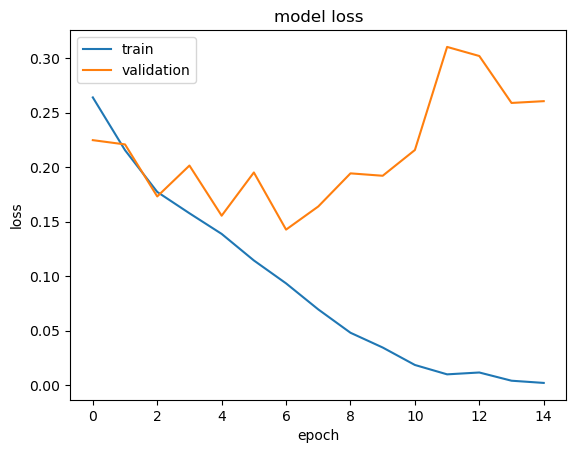

In [41]:
plotLosses(history)

In [42]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=1)


16/16 [==============================] - 0s 22ms/step - loss: 0.2607 - accuracy: 0.9540


In [43]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.2606601417064667, 0.9539999961853027]


The Original Model is fairly Accurate, at 94.45 and 0.29 loss, But is slightly more accurate when callbacks are added

['loss', 'accuracy']
[0.2606601417064667, 0.9539999961853027]

In [44]:
#model_dir = os.path.join("output","my_model",)
#model.save('output\\my_model')
model.save('output\\hmodel.h5')

INFO:tensorflow:Assets written to: output\my_model\assets


INFO:tensorflow:Assets written to: output\my_model\assets


Use Model To Evaluate Random Image

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1605888   
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                      

1/1 [==============================] - 0s 20ms/step
This was detected as being a Ship


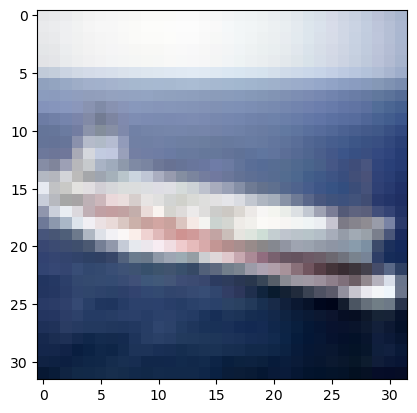

In [51]:

chosen_index = 54 #Test Image 55
probab = model.predict(test_data[chosen_index].reshape(1,32,32,3)) # Set to a numpy array of correct input data.
plt.imshow(test_data[chosen_index])
probab_list = probab.tolist()[0]
label_names = ["Non-Ship","Ship"]
max_number = max(probab_list)
index = probab_list.index(max_number)
print("This was detected as being a",label_names[index])